In [27]:
%load_ext autoreload
%autoreload 2
from functional_neural_networks.dense import FunctionalDense
from functional_neural_networks.convolution import FunctionalConvolution
from hyperopt.fnn import HyperOptFnn
from hyperopt.sklearn_gridsearch import HyperOptScikitFda
from images import images_path
from shapley.shapley_fda import ShapleyFda
from skfda.datasets import fetch_tecator
from skfda.misc.operators import LinearDifferentialOperator
from skfda.misc.regularization import L2Regularization
from skfda.ml.regression import KNeighborsRegressor, LinearRegression
from skfda.representation.basis import BSplineBasis
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import train_test_split
from utils.predict_np import predict_from_np
from utils.utils_workflow import compute_mean_value, l2_reg, plot_step_fn, predict_no_verbose_squeeze
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory

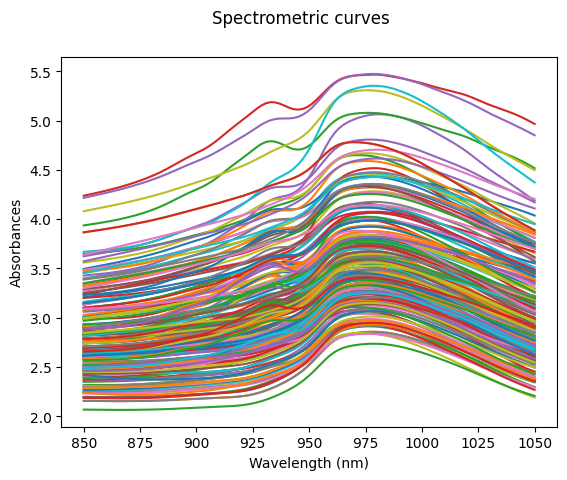

In [2]:
X, y = fetch_tecator(return_X_y=True, as_frame=True)
f = X.iloc[:, 0].values
fat = y['fat'].values
zzz = f.plot()

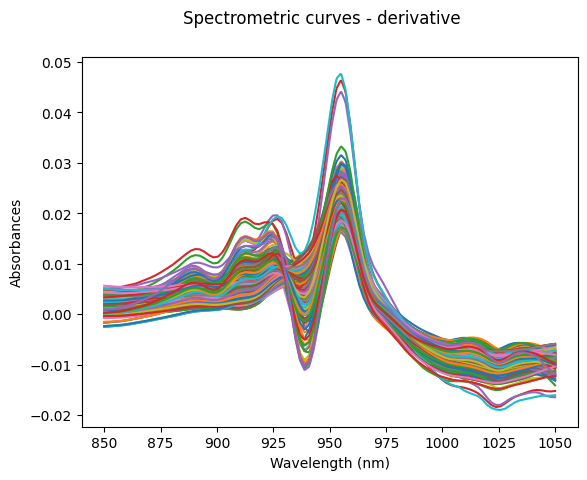

In [3]:
df = f.derivative()
df.dataset_name = f"{df.dataset_name} - derivative"
zzz = df.plot()

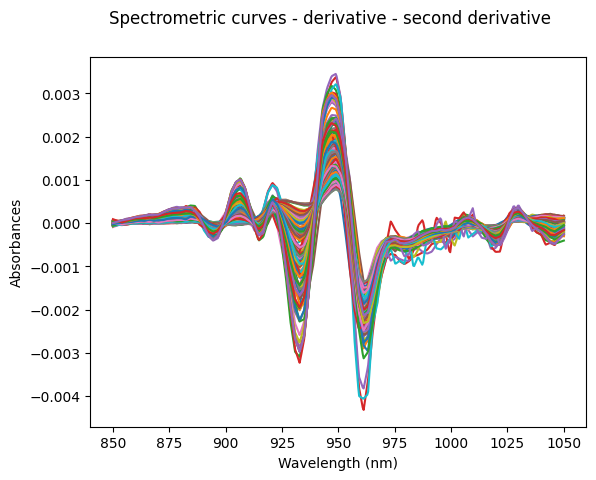

In [4]:
ddf = f.derivative(order=2)
ddf.dataset_name = f"{df.dataset_name} - second derivative"
fig = ddf.plot()

# Data treatment

In [5]:
n_basis_representation = 31
domain_range = f.domain_range[0]
basis_bsplines = BSplineBasis(
    n_basis=n_basis_representation,
    domain_range=domain_range
)

In [6]:
abscissa_points = np.array([x for x in f.grid_points])
abscissa_points = abscissa_points[0, :]
print(type(abscissa_points))
print(abscissa_points.shape)

<class 'numpy.ndarray'>
(100,)


(215, 100)
(128, 100)
(32, 100)
(55, 100)


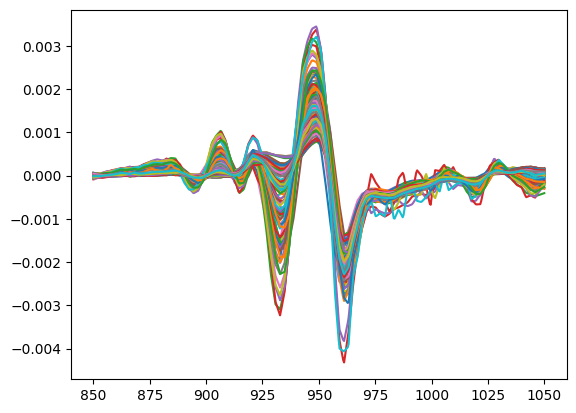

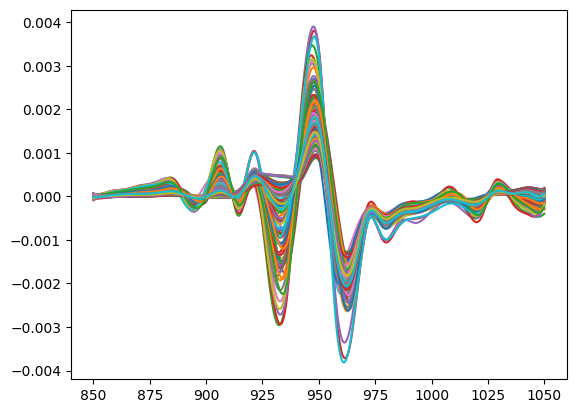

In [7]:
# Divide intro train, val and test
last_id_train_val = 160
rate_val = 0.2
# Get the data
X_np = np.squeeze(ddf.data_matrix)
X_full = X_np[:last_id_train_val, :]
target_full = fat[:last_id_train_val]
X_train, X_validation, target_train, target_validation = train_test_split(
    X_full,
    target_full,
    test_size=rate_val,
    random_state=4
)

X_test = X_np[last_id_train_val:, :]
target_test = fat[last_id_train_val:]

# To Grid
X_train_grid = FDataGrid(X_train, f.grid_points)
X_validation_grid = FDataGrid(X_validation, f.grid_points)
X_test_grid = FDataGrid(X_test, f.grid_points)
X_full_grid = FDataGrid(X_full, f.grid_points)

# To basis
X_train_bspline = X_train_grid.to_basis(basis_bsplines)
X_validation_bspline = X_validation_grid.to_basis(basis_bsplines)
X_test_bspline = X_test_grid.to_basis(basis_bsplines)
X_full_bspline = X_full_grid.to_basis(basis_bsplines)

print(X_np.shape)
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
zzz = X_full_grid.plot()
zzz = X_full_bspline.plot()

# Linear model

In [8]:
np.var(target_train)

153.16060974121095

In [9]:
ss_target_train = np.var(target_train) * target_train.shape[0]
print(ss_target_train)

19604.558046875


In [10]:
hyperopt_lm = HyperOptScikitFda(
    LinearRegression,
    abscissa_points=abscissa_points,
    domain_range=domain_range,
)

reg_list = [l2_reg(np.exp(x) * ss_target_train) for x  in np.arange(-30, 5, 3)]
#reg_list = [l2_reg(x) for x  in np.arange(0.01, 1, 0.05)]
reg_list.append(None)
params_lm = {
    "regularization": reg_list
}
hist_lm = hyperopt_lm.search(
    params=params_lm,
    X_train=X_train_bspline,
    y_train=target_train,
    X_val=X_validation_bspline,
    y_val=target_validation
)

In [11]:
print(len(reg_list))
print(reg_list)

13
[L2Regularization(linear_operator=LinearDifferentialOperator(
    	weights=(0, 0, 1),
    ),
                 regularization_parameter=1.8345206267339798e-09), L2Regularization(linear_operator=LinearDifferentialOperator(
    	weights=(0, 0, 1),
    ),
                 regularization_parameter=3.6847331784614734e-08), L2Regularization(linear_operator=LinearDifferentialOperator(
    	weights=(0, 0, 1),
    ),
                 regularization_parameter=7.400984430808258e-07), L2Regularization(linear_operator=LinearDifferentialOperator(
    	weights=(0, 0, 1),
    ),
                 regularization_parameter=1.4865274605293632e-05), L2Regularization(linear_operator=LinearDifferentialOperator(
    	weights=(0, 0, 1),
    ),
                 regularization_parameter=0.00029857702195794925), L2Regularization(linear_operator=LinearDifferentialOperator(
    	weights=(0, 0, 1),
    ),
                 regularization_parameter=0.005997079798951805), L2Regularization(linear_operator=LinearDiffer

In [12]:
best_params_lm = hist_lm.best_params_
print(best_params_lm)
best_model_lm = hyperopt_lm.cls_estimator(**best_params_lm)

{'regularization': L2Regularization(linear_operator=LinearDifferentialOperator(
    	weights=(0, 0, 1),
    ),
                 regularization_parameter=7.400984430808258e-07)}


In [13]:
_ = best_model_lm.fit(X_full_bspline, target_full)

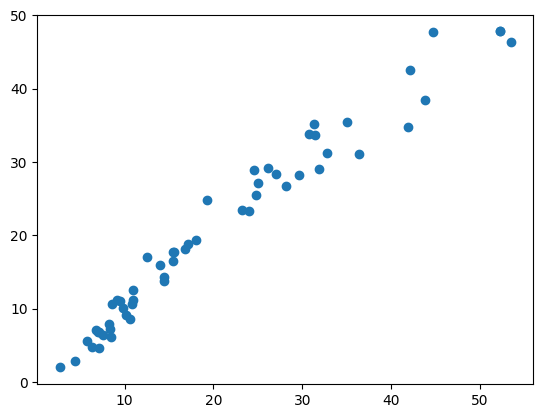

In [14]:
pred_lm = best_model_lm.predict(X_test_bspline)
plt.scatter(pred_lm, target_test)

In [15]:
np.corrcoef(pred_lm, target_test) ** 2

array([[1.        , 0.96197809],
       [0.96197809, 1.        ]])

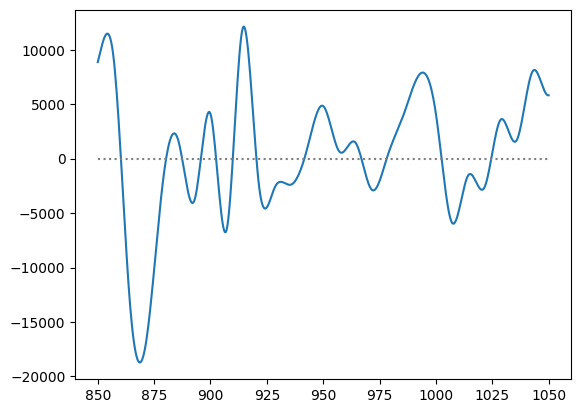

In [25]:
zzz = best_model_lm.coef_[0].plot()
plt.hlines(
        0,
        850,
        1050,
        color='tab:grey',
        linestyle="dotted",
        #linewidths=3
    )
#plt.xlabel(f.argument_names[0])
plt.savefig(os.path.join(images_path, "tecator_beta_lm.eps"), format="eps")
plt.savefig(os.path.join(images_path, "tecator_beta_lm.pdf"), format="pdf")

In [41]:
num_intervals = 50
num_permutations = 2000

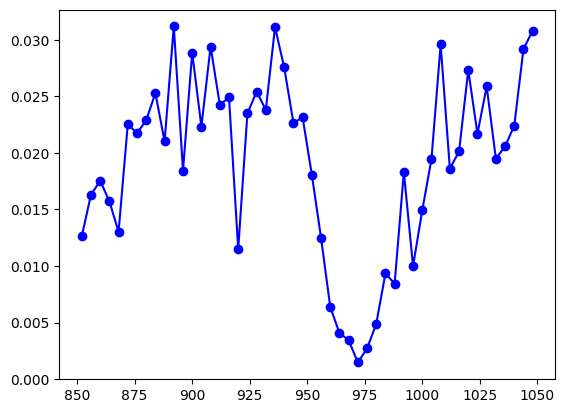

In [18]:
# Transform predict function to use a numpy array as input
pred_best_model_lm_fn = predict_from_np(
    grid_points=abscissa_points,
    domain_range=domain_range,
    basis=X_full_bspline.basis,
    predict_fn=best_model_lm.predict
)

shapley_fda_lm = ShapleyFda(
    predict_fn=pred_best_model_lm_fn,
    X=X_test,
    abscissa_points=abscissa_points,
    target=target_test,
    domain_range=domain_range,
    verbose=False,
)

values_shapley_lm = shapley_fda_lm.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_lm.plot()

# KNN

In [19]:
hyperopt_knn = HyperOptScikitFda(
    KNeighborsRegressor,
    abscissa_points=abscissa_points,
    domain_range=domain_range,
)

hist_knn = hyperopt_knn.search(
    params={"n_neighbors": range(3, 30, 1)},
    X_train=X_train,
    y_train=target_train,
    X_val=X_validation,
    y_val=target_validation
)

best_params_knn = hist_knn.best_params_
print(best_params_knn)
best_model_knn = hyperopt_knn.cls_estimator(**best_params_knn)
_ = best_model_knn.fit(X_full, target_full)

{'n_neighbors': 3}


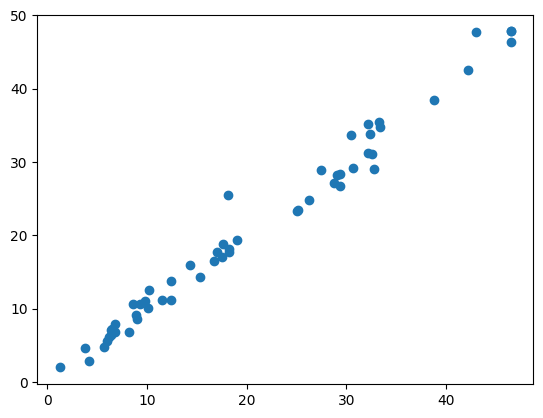

In [20]:
pred_knn = best_model_knn.predict(X_test)
plt.scatter(pred_knn, target_test)

In [21]:
np.corrcoef(pred_knn, target_test) ** 2

array([[1.        , 0.98079561],
       [0.98079561, 1.        ]])

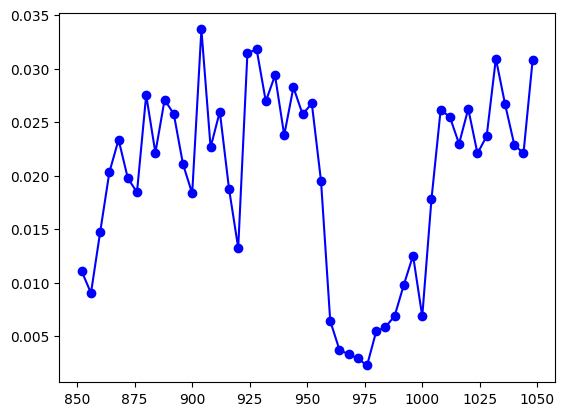

In [22]:
shapley_fda_knn = ShapleyFda(
    predict_fn=best_model_knn.predict,
    X=X_test,
    abscissa_points=abscissa_points,
    target=target_test,
    domain_range=domain_range,
    verbose=False,
)

values_shapley_knn = shapley_fda_knn.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_knn.plot()

# Neural Network no hyperparam

In [36]:
input_shape = (X_test.shape[1], 1)
filter_options = [
    {
        'n_filters': 20,
        'basis_options': {
            'n_functions': 7,
            'resolution': 25,
            'basis_type': 'Legendre'
        },
        'activation': 'elu'
    },
    {
        'n_filters': 5,
        'basis_options': {
            'n_functions': 7,
            'resolution': 25,
            'basis_type': 'Legendre'
        },
        'activation': 'elu'
    }
]
layer_options = [
    {
        'n_neurons': 1,
        'basis_options':
        {
            'n_functions': 1,
            'resolution': 52,
            'basis_type': 'Fourier'
        },
        'activation': 'elu',
        'pooling': True
    }
]
loss = 'mse'
inputs = tf.keras.layers.Input(shape=input_shape)
norm_axes = list(range(len(input_shape) - 1))
layer = tf.keras.layers.LayerNormalization(
    axis=norm_axes,
    center=False,
    scale=False,
    epsilon=1e-10,
    name='Normalization'
)(inputs)

for i, filter_option in enumerate(filter_options):
    layer = FunctionalConvolution(
        **filter_option,
        name=f'FunctionalConvolution_{i}'
    )(layer)

for i, layer_option in enumerate(layer_options):
    layer = FunctionalDense(
        **layer_option,
        name=f'FunctionalDense_{i}'
    )(layer)

outputs = layer
tf.keras.utils.set_random_seed(1234)
best_model_fnn = tf.keras.Model(inputs=inputs, outputs=outputs, name="Example_FNN")
best_model_fnn.summary()

Model: "Example_FNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Normalization                   │ (None, 100, 1)         │             0 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalConvolution_0         │ (None, 76, 20)         │           140 │
│ (FunctionalConvolution)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalConvolution_1         │ (None, 52, 5)          │           700 │
│ (FunctionalConvolution)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_0               │ (None, 1)              │             5 │
│ (FunctionalDense)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 845 (3.30 KB)

 Trainable params: 845 (3.30 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
best_model_fnn.compile(loss=loss, optimizer='adam')
best_model_fnn.fit(
    X_train,
    target_train,
    epochs=300,
    validation_data=(X_validation, target_validation),
    batch_size=64,
    #steps_per_epoch=1000,
    verbose=0
)

In [38]:
pred_validation_fnn = best_model_fnn.predict(X_validation)
print(np.mean((pred_validation_fnn[:, 0] - target_validation))**2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2.982395083883782


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


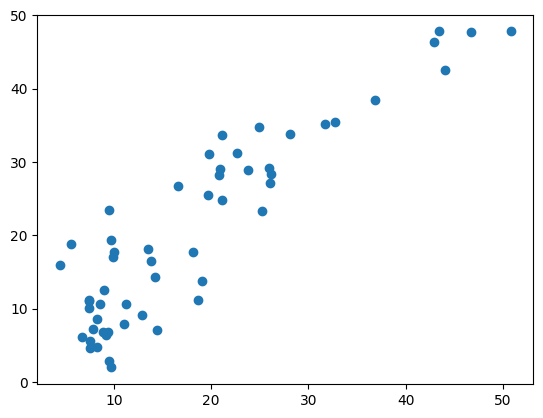

In [39]:
pred_fnn = best_model_fnn.predict(X_test)
plt.scatter(pred_fnn, target_test)

In [40]:
np.corrcoef(pred_fnn[:, 0], target_test) ** 2

array([[1.        , 0.81957309],
       [0.81957309, 1.        ]])

In [ ]:
shapley_fda_fnn = ShapleyFda(
    predict_fn=predict_no_verbose_squeeze(best_model_fnn.predict),
    X=X_test,
    abscissa_points=abscissa_points,
    target=target_test,
    domain_range=domain_range,
    verbose=True,
)

values_shapley_fnn = shapley_fda_fnn.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_fnn.plot()

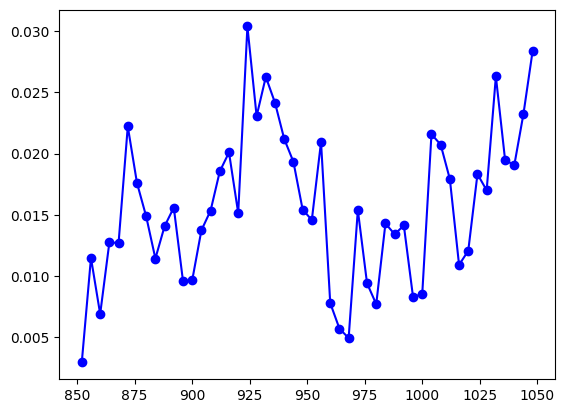

In [42]:
shapley_fda_fnn = ShapleyFda(
    predict_fn=predict_no_verbose_squeeze(best_model_fnn.predict),
    X=X_test,
    abscissa_points=abscissa_points,
    target=target_test,
    domain_range=domain_range,
    verbose=False,
)

values_shapley_fnn = shapley_fda_fnn.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_fnn.plot()

# Data treatment

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Num intervals: 50
Range value: 200.0
Factor: 0.25


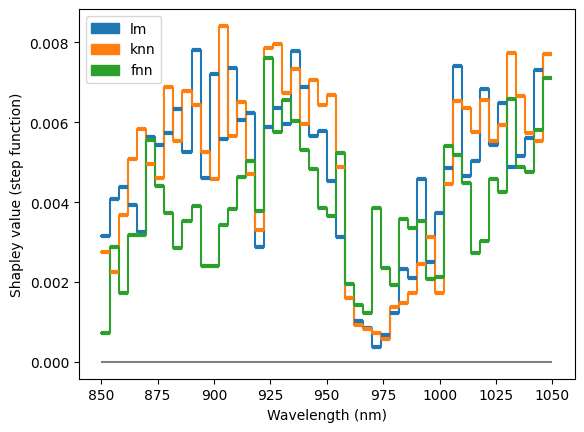

In [45]:
header = compute_mean_value([x[0] for x in values_shapley_lm])
x_min = [x[0][0] for x in values_shapley_lm]
x_max = [x[0][1] for x in values_shapley_lm]
models_obtained = ["lm", "knn", "fnn"]
shapley_all_models = np.row_stack(
    (
        shapley_fda_lm.shapley_values[1], 
        shapley_fda_knn.shapley_values[1],
        shapley_fda_fnn.shapley_values[1]
    )
)
plot_step_fn(
    x_min=x_min,
    x_max=x_max,
    values=shapley_all_models,
    colors=['tab:blue', 'tab:orange', 'tab:green'],
    models=models_obtained,
    domain_range=domain_range,
    x_lab=f.argument_names[0],
    y_lab="Shapley value (step function)",
    is_tecator=True,
    plt_h_line=True,
    plot_v_line=False, 
)
plt.savefig(os.path.join(images_path, "tecator_step_fn.eps"), format="eps")
plt.savefig(os.path.join(images_path, "tecator_step_fn.pdf"), format="pdf")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


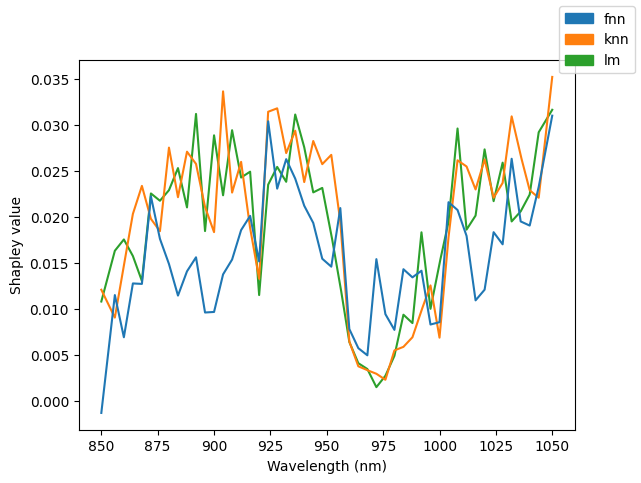

In [46]:
shapley_grid = FDataGrid(
    data_matrix=shapley_all_models,
    grid_points=header,
    domain_range=domain_range,
    sample_names=models_obtained,
    coordinate_names=("Shapley value", ),
    argument_names=f.argument_names
)
zzz = shapley_grid.plot(
    group=models_obtained,
    legend=True,
)
plt.savefig(os.path.join(images_path, "tecator_shapley.eps"), format="eps")
plt.savefig(os.path.join(images_path, "tecator_shapley.pdf"), format="pdf")